Đề tài: Đeo khẩu trang đúng cách
Thành viên nhóm:21520235 - Phạm Quang Hiếu

1. Mô tả bài toán: Input, Output, các ngữ cảnh ứng dụng. (Nên tham khảo và ghi rõ nguồn)
- Bài toán phát hiện đeo khẩu trang không đúng cách hoặc không đeo khẩu trang
- Input: Dữ liệu đầu vào là 1 hình ảnh (video được trích xuất từ camera) gồm 1 hoặc nhiều người 
- Output: Kết quả đầu ra là xuất ra một khung hình có tất cả nhãn được dự đoán

Ví dụ : 
- Ngữ cảnh ứng dụng: 
    + Ứng dụng trong camera bệnh viện, nơi đông người để biết được người không đeo khẩu trang hoặc đeo không đúng cách
    + Làm đồ án môn học máy học.
2. Mô tả về bộ dữ liệu:
+ cách thức xây dựng bộ dữ liệu : bộ dữ liệu hoàn toàn 100% trên kaggle (cụ thể là ở link: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection) 
+ số lượng, độ đa dạng: gồm 853 hình ảnh tương ứng với 853 annotations chứa thông tin các face và nhãn mask, có 3 nhãn là With mask, Without mask, Mask worn incorrectly
+ các thao tác tiền xử lý dữ liệu: 
    - Lấy thông tin trong file xml để trích xuất dữ liệu về face và nhãn mask rồi cắt hình ảnh thành các hình ảnh gồm các face khác nhau và gắn nhãn cho nó rồi lưu vào folder chuẩn bị cho việc huấn luyện mô hình 
    - chuẩn hóa kích thước hình ảnh (224,224), tăng cường dữ liệu (lật, phóng, méo, dịch chuyển phải trái, xoay)
+ phân chia (split) - train/dev/test: train/test là 80/20, test/val là 30/70

3. Mô tả về đặc trưng
+ feature engineering: chuẩn hóa kích thước (224, 224) và chuẩn hóa (0, 1)
+ data processing pipeline: 
4. Mô tả về thuật toán máy học
- lấy mô hình phát hiện khuôn mặt đã được huấn luyện từ link: https://github.com/keyurr2/face-detection/blob/master/res10_300x300_ssd_iter_140000.caffemodel
- dùng cnn đẻe phân loại 3 nhãn với đầu vào là khuôn mặt đã nhận dạng được đã cắt
5. Cài đặt, tinh chỉnh tham số
(dự kiến)
6. Đánh giá kết quả, kết luận
(dự kiến)

xây dựng từ tập dữ liệu WIDER FACE
mô hình SSD với kiến trúc ResNet-10

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # image plotting
import os
import time

2. Mô tả về bộ dữ liệu:

In [2]:
# đường dẫn đầu vào image
input_data_path = './kaggle/input/face-mask-detection/images'
# đường đẫn đầu vào annotations
annotations_path = "./kaggle/input/face-mask-detection/annotations"
# mảng danh sách tên file hình ảnh
images = [*os.listdir("./kaggle/input/face-mask-detection/images")]
# đường dẫn sau xử lý dữ liệu
output_data_path =  './kaggle/working'

In [3]:
# để phân tích định dạng file xml
import xml.etree.ElementTree as ET 

def parse_annotation(path):
    tree = ET.parse(path) 
    root = tree.getroot() 
    constants = {}
    # lấy tất cả phần tử 'object' trong phần tử gốc (annotation)
    objects = [child for child in root if child.tag == 'object']
    # duyệt từng phần tử trong tree
    for element in tree.iter():
        if element.tag == 'filename':
            # lấy tên file nhưng bỏ 4 phần tử cuối (bỏ .xml)
            constants['file'] = element.text[0:-4]
        # lưu trữ kích thước và lớp ảnh
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    # thông tin của tất cả object trong 1 annotation
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    # gộp các dictionary lại vơi nhau
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   

# thông tin của object trong annotation
def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        # tên nhãn của object
        if param.tag == 'name':
            params['name'] = param.text
        # kích thước nhãn 
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
# gộp dictionary với nhau
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [4]:
# thư viện có hàm glob để tìm các thư mục,tệp dựa trên mẫu khớp
import glob
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]
dataset


[[{'file': 'maksssksksss0',
   'width': 512,
   'height': 366,
   'depth': 3,
   'name': 'without_mask',
   'xmin': 79,
   'ymin': 105,
   'xmax': 109,
   'ymax': 142},
  {'file': 'maksssksksss0',
   'width': 512,
   'height': 366,
   'depth': 3,
   'name': 'with_mask',
   'xmin': 185,
   'ymin': 100,
   'xmax': 226,
   'ymax': 144},
  {'file': 'maksssksksss0',
   'width': 512,
   'height': 366,
   'depth': 3,
   'name': 'without_mask',
   'xmin': 325,
   'ymin': 90,
   'xmax': 360,
   'ymax': 141}],
 [{'file': 'maksssksksss1',
   'width': 400,
   'height': 156,
   'depth': 3,
   'name': 'with_mask',
   'xmin': 321,
   'ymin': 34,
   'xmax': 354,
   'ymax': 69},
  {'file': 'maksssksksss1',
   'width': 400,
   'height': 156,
   'depth': 3,
   'name': 'with_mask',
   'xmin': 224,
   'ymin': 38,
   'xmax': 261,
   'ymax': 73},
  {'file': 'maksssksksss1',
   'width': 400,
   'height': 156,
   'depth': 3,
   'name': 'with_mask',
   'xmin': 299,
   'ymin': 58,
   'xmax': 315,
   'ymax': 81},

In [5]:
# làm phẳng
full_dataset = sum(dataset, []) 
full_dataset

[{'file': 'maksssksksss0',
  'width': 512,
  'height': 366,
  'depth': 3,
  'name': 'without_mask',
  'xmin': 79,
  'ymin': 105,
  'xmax': 109,
  'ymax': 142},
 {'file': 'maksssksksss0',
  'width': 512,
  'height': 366,
  'depth': 3,
  'name': 'with_mask',
  'xmin': 185,
  'ymin': 100,
  'xmax': 226,
  'ymax': 144},
 {'file': 'maksssksksss0',
  'width': 512,
  'height': 366,
  'depth': 3,
  'name': 'without_mask',
  'xmin': 325,
  'ymin': 90,
  'xmax': 360,
  'ymax': 141},
 {'file': 'maksssksksss1',
  'width': 400,
  'height': 156,
  'depth': 3,
  'name': 'with_mask',
  'xmin': 321,
  'ymin': 34,
  'xmax': 354,
  'ymax': 69},
 {'file': 'maksssksksss1',
  'width': 400,
  'height': 156,
  'depth': 3,
  'name': 'with_mask',
  'xmin': 224,
  'ymin': 38,
  'xmax': 261,
  'ymax': 73},
 {'file': 'maksssksksss1',
  'width': 400,
  'height': 156,
  'depth': 3,
  'name': 'with_mask',
  'xmin': 299,
  'ymin': 58,
  'xmax': 315,
  'ymax': 81},
 {'file': 'maksssksksss1',
  'width': 400,
  'height':

In [6]:
df = pd.DataFrame(full_dataset)
df.shape

(4072, 9)

In [7]:
df.head()

file  width  height  depth          name  xmin  ymin  xmax  ymax
0  maksssksksss0    512     366      3  without_mask    79   105   109   142
1  maksssksksss0    512     366      3     with_mask   185   100   226   144
2  maksssksksss0    512     366      3  without_mask   325    90   360   141
3  maksssksksss1    400     156      3     with_mask   321    34   354    69
4  maksssksksss1    400     156      3     with_mask   224    38   261    73

In [8]:
# lấy mãu test 0
final_test_image = 'maksssksksss0' # chose the image
df_final_test = df.loc[df["file"] == final_test_image] # create a separate dataframe which contain only the people in this specific image
images.remove(f'{final_test_image}.png') # remove the image from the full dataset
df = df.loc[df["file"] != final_test_image] # remove the information of the image from the full dataset

In [10]:
df_final_test.head()

file  width  height  depth          name  xmin  ymin  xmax  ymax
0  maksssksksss0    512     366      3  without_mask    79   105   109   142
1  maksssksksss0    512     366      3     with_mask   185   100   226   144
2  maksssksksss0    512     366      3  without_mask   325    90   360   141

In [9]:
# đổi tên cột file và name
df.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)
df_final_test.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)
df.head()

file_name  width  height  depth      label  xmin  ymin  xmax  ymax
3  maksssksksss1    400     156      3  with_mask   321    34   354    69
4  maksssksksss1    400     156      3  with_mask   224    38   261    73
5  maksssksksss1    400     156      3  with_mask   299    58   315    81
6  maksssksksss1    400     156      3  with_mask   143    74   174   115
7  maksssksksss1    400     156      3  with_mask    74    69    95    99

In [10]:
df["label"].value_counts()

label
with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: count, dtype: int64

Text(0, 0.5, 'Label')

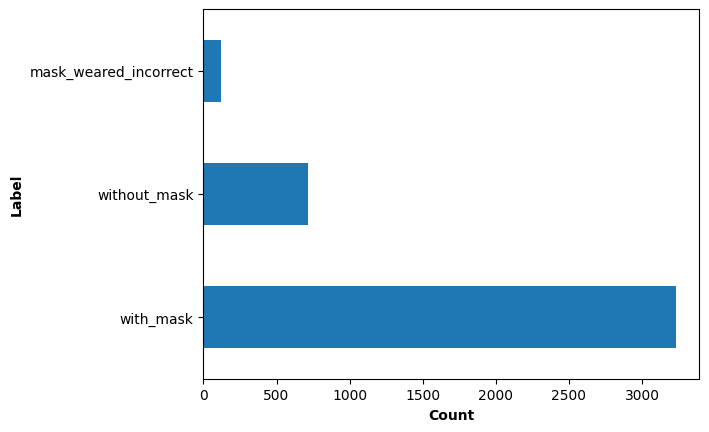

In [11]:
# vẽ trực quan số lượng nhãn
df["label"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Label', fontsize = 10, fontweight = 'bold')

In [12]:
# tạo đường dẫn
labels = df['label'].unique()
directory = ['train', 'test', 'val']
output_data_path =  './kaggle/working'


import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        if not os.path.exists(path):
            os.makedirs(path)

In [13]:
# cắt hình ảnh khuôn mặt đeo khẩu trang (mở rộng 10% theo chiều ngang dọc)
from PIL import Image
def crop_img(image_path, x_min, y_min, x_max, y_max):
    
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [14]:
# hàm lấy tên + dataframe của image -> chia thành các khuôn mặt khác nhau
def extract_faces(image_name, image_info):
    
    faces = []
    df_one_img = image_info[image_info['file_name'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'label']]
    # duyệt từng object trong 1 annotation
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        # lưu hình ảnh đã cắt, nhãn, tên
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [15]:
cropped_faces = [extract_faces(img, df) for img in images]
cropped_faces

[[(<PIL.Image.Image image mode=RGBA size=39x42>,
   'with_mask',
   'maksssksksss1_(321, 34)'),
  (<PIL.Image.Image image mode=RGBA size=45x42>,
   'with_mask',
   'maksssksksss1_(224, 38)'),
  (<PIL.Image.Image image mode=RGBA size=20x27>,
   'with_mask',
   'maksssksksss1_(299, 58)'),
  (<PIL.Image.Image image mode=RGBA size=37x49>,
   'with_mask',
   'maksssksksss1_(143, 74)'),
  (<PIL.Image.Image image mode=RGBA size=25x36>,
   'with_mask',
   'maksssksksss1_(74, 69)'),
  (<PIL.Image.Image image mode=RGBA size=36x32>,
   'with_mask',
   'maksssksksss1_(191, 67)'),
  (<PIL.Image.Image image mode=RGBA size=27x24>,
   'with_mask',
   'maksssksksss1_(21, 73)'),
  (<PIL.Image.Image image mode=RGBA size=35x35>,
   'with_mask',
   'maksssksksss1_(369, 70)'),
  (<PIL.Image.Image image mode=RGBA size=34x39>,
   'without_mask',
   'maksssksksss1_(83, 56)')],
 [(<PIL.Image.Image image mode=RGBA size=116x140>,
   'with_mask',
   'maksssksksss10_(98, 267)')],
 [(<PIL.Image.Image image mode=RGBA

In [16]:
# làm phẳng
flat_cropped_faces = sum(cropped_faces, [])
flat_cropped_faces

[(<PIL.Image.Image image mode=RGBA size=39x42>,
  'with_mask',
  'maksssksksss1_(321, 34)'),
 (<PIL.Image.Image image mode=RGBA size=45x42>,
  'with_mask',
  'maksssksksss1_(224, 38)'),
 (<PIL.Image.Image image mode=RGBA size=20x27>,
  'with_mask',
  'maksssksksss1_(299, 58)'),
 (<PIL.Image.Image image mode=RGBA size=37x49>,
  'with_mask',
  'maksssksksss1_(143, 74)'),
 (<PIL.Image.Image image mode=RGBA size=25x36>,
  'with_mask',
  'maksssksksss1_(74, 69)'),
 (<PIL.Image.Image image mode=RGBA size=36x32>,
  'with_mask',
  'maksssksksss1_(191, 67)'),
 (<PIL.Image.Image image mode=RGBA size=27x24>,
  'with_mask',
  'maksssksksss1_(21, 73)'),
 (<PIL.Image.Image image mode=RGBA size=35x35>,
  'with_mask',
  'maksssksksss1_(369, 70)'),
 (<PIL.Image.Image image mode=RGBA size=34x39>,
  'without_mask',
  'maksssksksss1_(83, 56)'),
 (<PIL.Image.Image image mode=RGBA size=116x140>,
  'with_mask',
  'maksssksksss10_(98, 267)'),
 (<PIL.Image.Image image mode=RGBA size=68x70>,
  'with_mask',
  'm

In [17]:
# lọc danh sách hình ảnh theo nhãn để xếp vào thư mục theo nhãn
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [18]:
print(f'số hình ảnh đeo đúng cách: {len(with_mask)}')
print(f'số hình ảnh không đeo khẩu trang: {len(without_mask)}')
print(f'số hình ảnh đeo khẩu trang không đúng cách: {len(mask_weared_incorrect)}')

số hình ảnh đeo đúng cách: 3231
số hình ảnh không đeo khẩu trang: 715
số hình ảnh đeo khẩu trang không đúng cách: 123


In [19]:
# phân chia dữ liệu train:test(80:20), test:val(70:30)
from sklearn.model_selection import train_test_split

train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [20]:
# hàm Lưu hình ảnh vào thư mục
def save_image(image, image_name, output_data_path,  dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)   

In [21]:
# Train set


for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')
        
# Test set

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
    
# Val set
    
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')

In [22]:

batch_size = 8
epochs = 100

3. Mô tả về đặc trưng

In [23]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255, #chuẩn hóa (0,1)
    horizontal_flip=True, #lật theo chiều dọc
    zoom_range=0.1, #phóng to 10%
    shear_range=0.2, # làm méo ảnh
    width_shift_range=0.1, #dịch chuyển ngang 10%
    height_shift_range=0.1, #dịch chuyển dọc 10%
    rotation_range=4, #xoay 4 độ
    vertical_flip=False 

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 
# train data
train_generator = datagen.flow_from_directory(
    directory='./kaggle/working/train', 
    target_size = (224,224),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='./kaggle/working/val', 
    target_size = (224,224),
    class_mode="categorical", 
    batch_size=batch_size, 
    shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='./kaggle/working/test', 
    target_size = (224,224),
    class_mode="categorical", 
    batch_size=batch_size, 
    shuffle=False
)

Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


5. Cài đặt, tinh chỉnh tham số

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_custom = Sequential()
model_custom.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (224,224,3)))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Dropout(0.3))
model_custom.add(Flatten())
model_custom.add(Dense(units = 500, activation = 'relu'))
model_custom.add(Dropout(0.3))
model_custom.add(Dense(units = 3, activation = 'softmax'))


model_custom.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [25]:
data_size = len(train_generator) 

print(f"data_size: {data_size}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
print(f"val_steps: {val_steps}")

data_size: 407
steps_per_epoch: 50
val_steps: 9


In [26]:
# Compiling the model
import tensorflow as tf
model_custom.compile(
    optimizer="adam",
    loss= tf.keras.losses.CategoricalFocalCrossentropy(
        gamma=1.5,
        name='categorical_focal_crossentropy'
    ),
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

# nếu 8 epochs liên tiếp mà validation loss không được cải thiện thì dừng, restore_best_weights =True để lấy trọng số mô hình tốt nhất
# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True )

# điều chỉnh tốc độ học tập để có thể tăng khả năng hội tụ
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [27]:
# Fit the model on train data

model_custom_history = model_custom.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[lrr]
)
# lưu mô hình
model_custom.save('model_custom2.h5')

C:\Users\admin\AppData\Local\Temp\ipykernel_19220\173091310.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_custom_history = model_custom.fit_generator(


Epoch 1/100
50/50 [==============================] - 22s 412ms/step - loss: 0.1562 - accuracy: 0.7275 - recall: 0.6375 - precision: 0.7822 - auc: 0.8449 - val_loss: 0.0769 - val_accuracy: 0.7778 - val_recall: 0.7639 - val_precision: 0.7857 - val_auc: 0.9406 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 20s 393ms/step - loss: 0.0455 - accuracy: 0.8700 - recall: 0.8275 - precision: 0.8946 - auc: 0.9597 - val_loss: 0.0362 - val_accuracy: 0.8194 - val_recall: 0.8056 - val_precision: 0.9355 - val_auc: 0.9811 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 19s 386ms/step - loss: 0.0462 - accuracy: 0.8625 - recall: 0.7925 - precision: 0.9135 - auc: 0.9627 - val_loss: 0.0369 - val_accuracy: 0.8889 - val_recall: 0.8333 - val_precision: 0.9375 - val_auc: 0.9798 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 19s 380ms/step - loss: 0.0289 - accuracy: 0.9225 - recall: 0.8850 - precision: 0.9440 - auc: 0.9835 - val_loss: 0.0260 - val_accuracy:

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
# Evaluate model performance on test data
model_custom_loss, model_custom_acc, custom_recall, custom_precision, custom_auc = model_custom.evaluate(test_generator)
print("Our Custom Model has a loss of %.2f and accuracy %.2f%%" % (model_custom_loss, model_custom_acc*100))
print("Our Custom Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (custom_recall*100, custom_precision*100, custom_auc*100))

31/31 [==============================] - 2s 77ms/step - loss: 0.0177 - accuracy: 0.9342 - recall: 0.9300 - precision: 0.9456 - auc: 0.9924
Our Custom Model has a loss of 0.02 and accuracy 93.42%
Our Custom Model has a recall of 93.00%, precision of 94.56% and auc of 99.24%


In [37]:
def plot_loss_and_accuracy(histories):
    fig, ax = plt.subplots(2,2, figsize=(12, 6))
    
    for i, history in enumerate(histories):
        history_df = pd.DataFrame(history)
        history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[i,0])
        ax[i,0].set(xlabel = 'epoch number', ylabel = 'loss')
        ax[i,0].set_title(f"Model {i+1} Loss")
        
        history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[i,1])
        ax[i,1].set(xlabel = 'epoch number', ylabel = 'accuracy')
        ax[i,1].set_title(f"Model {i+1} Accuracy")
        
    fig.tight_layout()
    plt.show()

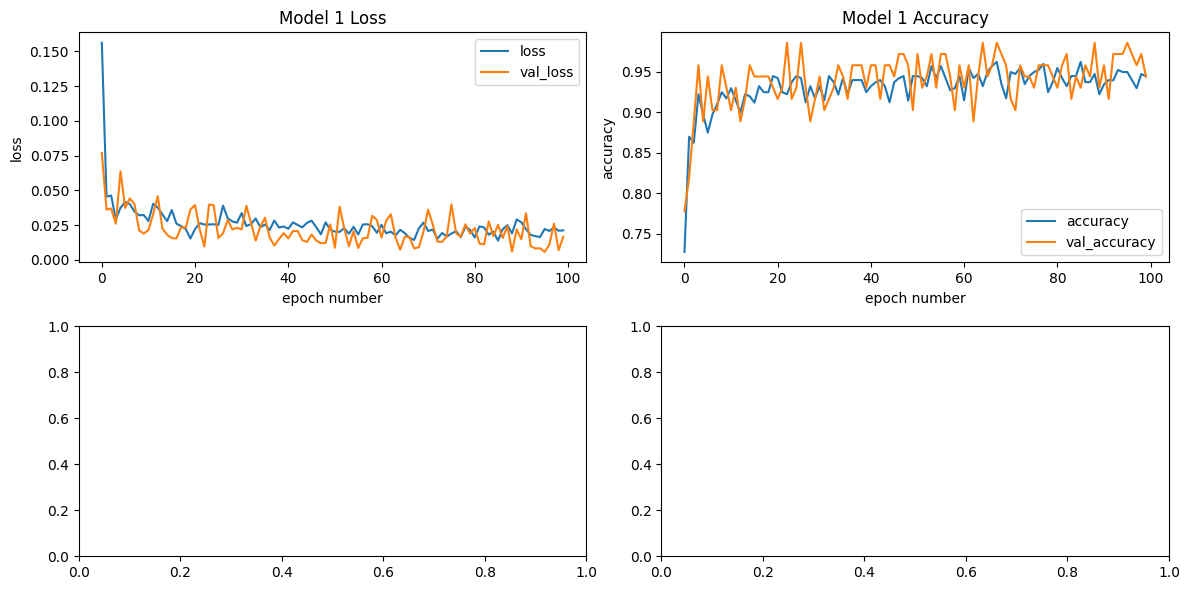

In [38]:
plot_loss_and_accuracy([model_custom_history.history])

In [39]:
custom_predictions = model_custom.predict(test_generator)
print("predictions shape:", custom_predictions.shape)

31/31 [==============================] - 2s 50ms/step
predictions shape: (243, 3)


31/31 [==============================] - 2s 48ms/step
Class Predicted: without_mask , True label: without_mask\maksssksksss792_(196, 36).png for Custom Model


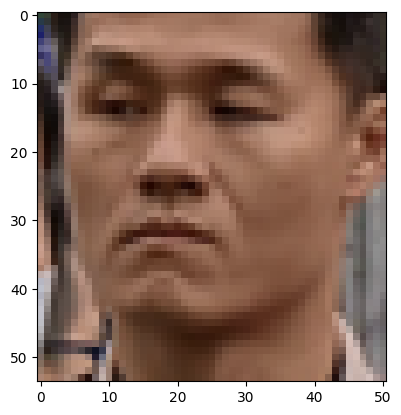

In [40]:
import cv2

paths = test_generator.filenames # mảng chứa đường dẫn của tên file test
y_pred_custom = model_custom.predict(test_generator).argmax(axis=1) # mảng chứa dự đoán tất cả nhãn
classes = test_generator.class_indices  # danh sách tên nhãn

a_img_rand = np.random.randint(0,len(paths))   # chọn ngẫu nhiên thứ tự hình ảnh
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))  
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # ảnh đầu ra có màu

# xuất hình ảnh được chọn ngẫu nhiên
plt.imshow(colored_img)
# nhãn đúng
true_label = paths[a_img_rand].split('/')[0]
# dự đoán nhãn
predicted_label = list(classes)[y_pred_custom[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label} for Custom Model')

In [41]:
y_true = test_generator.labels
y_pred_custom  = model_custom.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

31/31 [==============================] - 2s 50ms/step


1/1 [==============================] - 0s 52ms/step


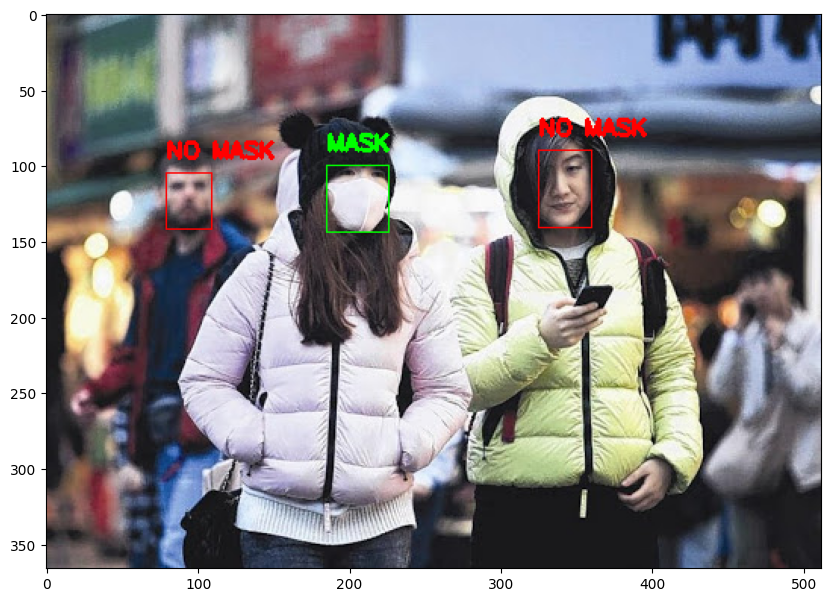

In [42]:
import cv2
img = cv2.imread(os.path.join(input_data_path, f'{final_test_image}.png'))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#print(type(colored_img))
mask_label = {0:'MASK INCORRECT',1:'MASK', 2:'NO MASK'}
color_label = {0:(0,255,255),1:(0, 255,0), 2:(255,0,0)}
cropped_faces = extract_faces(f'{final_test_image}.png', df_final_test)

df_test_img = df_final_test[['xmin', 'ymin', 'xmax', 'ymax', 'label']]
#for row_num in range(len(df_test_img)):
for idx, face in enumerate(cropped_faces):    
    # print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    # print(x_min, y_min, x_max, y_max, label)
   
    resized_face = cv2.resize(np.array(face[0]),(224,224))
    # chuẩn hóa
    reshaped_face = np.reshape(resized_face,[1,224,224,3])/255.0
    # mảng lưu trũ tỉ lệ dự đoán của từng nhãn
    face_result = model_custom.predict(reshaped_face)

    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)

In [43]:
import tensorflow as tf
from tensorflow import keras
new_model = tf.keras.models.load_model('./model_custom2.h5')

new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [1]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import imutils
def detect_and_predict_mask(frame, faceNet, maskNet):
	# lấy kích thước frame(image) và chuyển kích thước để phù hợp với đầu vào mô hình
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224), (104.0, 177.0, 123.0))

	# chuyển blob thành face
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# khởi tạo danh sách khuôn mặt, vị trí, dự đoán nhãn
	faces = []
	locs = []
	preds = []


	# lặp lại phát hiện khuôn mặt
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# tính tọa độ face
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# đảm bảo kích thước box nằm trong giới hạn của frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# chuyển đổi thành RGB, thay đổi kích thước thành (224,224)
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))

			
			face = img_to_array(face)
			face = np.reshape(face,[224,224,3])/255.0
			# face = preprocess_input(face)

			# thêm face và kích thước vào list
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# đưa ra predict nếu phát hiện khuôn mặt
	if len(faces) > 0:
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	return (locs, preds)

In [2]:
import cv2
prototxtPath = "./face_detector/deploy.prototxt" #cấu hình network
weightsPath = "./face_detector/res10_300x300_ssd_iter_140000.caffemodel" #chứa các trọng số được đào tạo
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = load_model("model_custom2.h5")

In [46]:
frame = cv2.imread('./np-file-163630-jpeg-6249-16547-1171-4679-1702278198.jpg')

In [47]:
(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

(1, 1, 200, 7)
1/1 [==============================] - 0s 116ms/step


In [48]:
for (box, pred) in zip(locs, preds):
		(startX, startY, endX, endY) = box
		(mwi, mask, withoutMask) = pred

		classes = ["Mwi", "Mask", "WithoutMask"]
		index = np.argmax([mwi, mask, withoutMask])
		label = classes[index]
		if label == "Mask":
			color = (0, 255, 0)
		elif label == "WithoutMask":
			color = (0, 0, 255)
		else :
			color = (255, 0, 0)

		label = "{}: {:.2f}%".format(label, max(mwi, mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
		

In [49]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

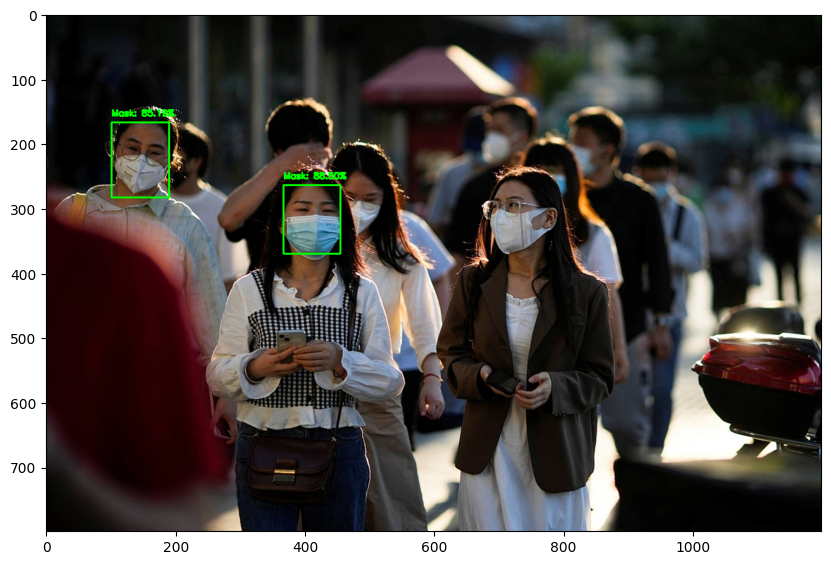

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))   
plt.imshow(frame)

In [51]:
frame1 = cv2.imread('./photo-1-16123214536631226328517.jpeg')

In [52]:
(locs1, preds1) = detect_and_predict_mask(frame1, faceNet, maskNet)

(1, 1, 200, 7)
1/1 [==============================] - 0s 43ms/step


In [53]:
for (box, pred) in zip(locs1, preds1):
		(startX, startY, endX, endY) = box
		(mwi, mask, withoutMask) = pred

		classes = ["Mwi", "Mask", "WithoutMask"]
		index = np.argmax([mwi, mask, withoutMask])
		label = classes[index]
		if label == "Mask":
			color = (0, 255, 0)
		elif label == "WithoutMask":
			color = (0, 0, 255)
		else :
			color = (255, 0, 0)

		label = "{}: {:.2f}%".format(label, max(mwi, mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame1, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame1, (startX, startY), (endX, endY), color, 2)

In [54]:
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)

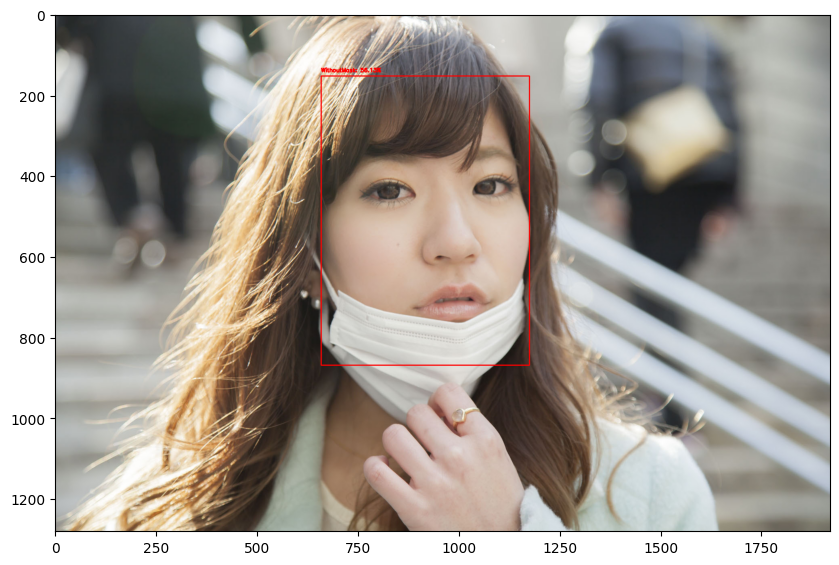

In [55]:
plt.figure(figsize=(10, 10))   
plt.imshow(frame1)

In [3]:
frame2 = cv2.imread('./maksssksksss0.png')

In [4]:
(locs2, preds2) = detect_and_predict_mask(frame2, faceNet, maskNet)

(1, 1, 200, 7)
1/1 [==============================] - 0s 338ms/step


In [5]:
for (box, pred) in zip(locs2, preds2):
		(startX, startY, endX, endY) = box
		(mwi, mask, withoutMask) = pred

		classes = ["Mwi", "Mask", "WithoutMask"]
		index = np.argmax([mwi, mask, withoutMask])
		label = classes[index]
		if label == "Mask":
			color = (0, 255, 0)
		elif label == "WithoutMask":
			color = (0, 0, 255)
		else :
			color = (255, 0, 0)

		label = "{}: {:.2f}%".format(label, max(mwi, mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame2, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame2, (startX, startY), (endX, endY), color, 2)

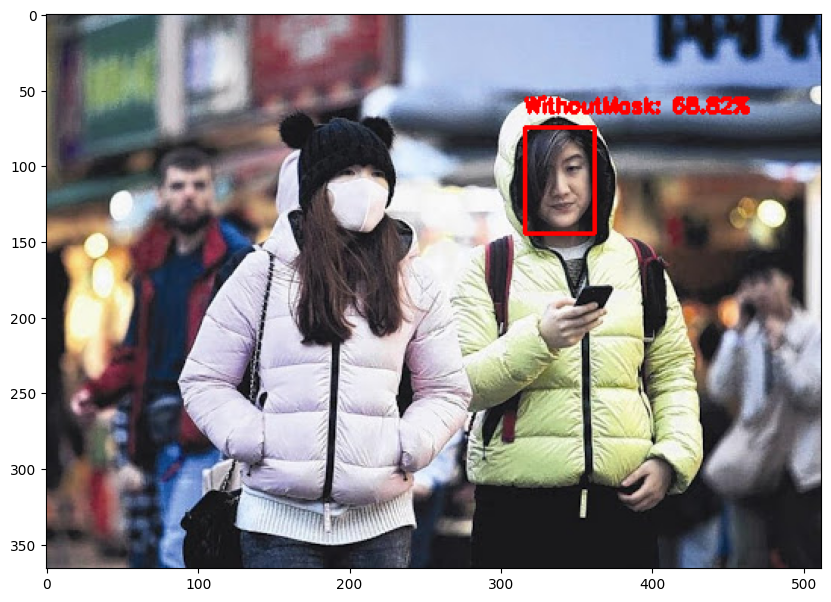

In [7]:
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))   
plt.imshow(frame2)

6. Đánh giá kết quả, kết luận
- Mô hình phát hiện khuôn mặt thực sự hoạt động không tốt trong việc phát hiện khuôn mặt có đeo khẩu trang, đeo vật dụng kín mặt vì mô hình được huấn luyện trên tập dữ liệu là khuôn mặt con người không che mặt
- Mô hình phân loại 3 nhãn khẩu trang cũng không thực sự hoạt động tốt lắm vì nó không phân biệt được mask_weared_inconrrect và with_mask vì dữ liệu ảnh train được cắt xén từ ảnh có nhiều người nên có một vài ảnh rất mờ, nhận dạng đến như mức khó nhận dạng bằng mắt thường và tập dữ liệu ủa nhãn mask_weared_inconrrect quá chênh lệch so với nhãn with_mask, without-mask.
=> Mô hình thuật toán này không thực sự hoạt động tốt
- Giải pháp, hướng phát triển: Có thể không sử dụng mô hình phát hiện khuôn mặt mà thay vào đó là sử dụng mô hình phát hiện đầu người để có thể dễ nhận dạng hơn. Ngoài ra chúng ta có thể lọc dữ liệu (loại bỏ ảnh mờ, khó nhận dạng), thu nhập nhiều dữ liệu hơn và cân bằng lại các số lượng nhãn lại với nhau.

In [2]:
!pip install --upgrade tensorflow_hub

   ---------------------------------------- 0.0/85.4 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.4 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.4 kB ? eta -:--:--
   ------------------- -------------------- 41.0/85.4 kB 279.3 kB/s eta 0:00:01
   ---------------------------------------- 85.4/85.4 kB 437.1 kB/s eta 0:00:00


In [30]:

import tensorflow as tf
import tensorflow_hub as hub
# we have to add some extra layers because 
# the input tensor shape at some point during the forward pass of the network became smaller than the filter size (3x3),
# which is causing a negative dimension size. This may be because of the MaxPooling layer being applied too many times or
# the input tensor is too small for the network architecture.
# One possible solution is to add padding to the MaxPooling layers with padding='same' argument.
# This will add zero-padding to the input so that the output size will remain the same.
    
model_mobilenet = tf.keras.Sequential([
    hub.KerasLayer('https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-96-feature-vector/versions/2',
                  trainable=False, input_shape=(96,96,3)),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Recall', 'Precision', 'AUC'])
model_mobilenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              410208    
                                                                 
 dense_2 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 414051 (1.58 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 410208 (1.56 MB)
_________________________________________________________________


In [ ]:
# plot_model(model_mobilenet, show_shapes=True, show_layer_names=True)

In [31]:
# ReScaling the images to match the size.
train_generator = datagen.flow_from_directory(
    directory='./kaggle/working/train', 
    target_size = (96,96),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='./kaggle/working/val', 
    target_size = (96,96),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='./kaggle/working/test', 
    target_size = (96,96),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [32]:
# Fit Inception ion Train Data
model_mobilenet_history = model_mobilenet.fit(
    train_generator,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
    
)

Epoch 1/100
407/407 [==============================] - 17s 29ms/step - loss: 0.2876 - accuracy: 0.9001 - recall: 0.8703 - precision: 0.8839 - auc: 0.9657 - val_loss: 0.1456 - val_accuracy: 0.9583 - val_recall: 0.9583 - val_precision: 0.9079 - val_auc: 0.9897
Epoch 2/100
407/407 [==============================] - 11s 27ms/step - loss: 0.1982 - accuracy: 0.9333 - recall: 0.8903 - precision: 0.9391 - auc: 0.9819 - val_loss: 0.2302 - val_accuracy: 0.9028 - val_recall: 0.8056 - val_precision: 0.8923 - val_auc: 0.9770
Epoch 3/100
407/407 [==============================] - 12s 29ms/step - loss: 0.1758 - accuracy: 0.9388 - recall: 0.8946 - precision: 0.9442 - auc: 0.9856 - val_loss: 0.1656 - val_accuracy: 0.9444 - val_recall: 0.9444 - val_precision: 0.9444 - val_auc: 0.9896
Epoch 4/100
407/407 [==============================] - 11s 27ms/step - loss: 0.1641 - accuracy: 0.9462 - recall: 0.9004 - precision: 0.9470 - auc: 0.9862 - val_loss: 0.1480 - val_accuracy: 0.9444 - val_recall: 0.8472 - val_

In [33]:
model_mobilenet.save('model_mobilenet.h5')

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
# Evaluate model performance on test data
mobilenet_loss, mobilenet_acc, mobilenet_recall, mobilenet_precision, mobilenet_auc = model_mobilenet.evaluate(test_generator)
print("MobileNet Model has a loss of %.2f and accuracy %.2f%%" % (mobilenet_loss, mobilenet_acc*100))
print("MobileNet Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (mobilenet_recall*100, mobilenet_precision*100, mobilenet_auc*100))

31/31 [==============================] - 1s 18ms/step - loss: 0.1925 - accuracy: 0.9506 - recall: 0.8025 - precision: 0.9701 - auc: 0.9853
MobileNet Model has a loss of 0.19 and accuracy 95.06%
MobileNet Model has a recall of 80.25%, precision of 97.01% and auc of 98.53%


In [35]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
# Create the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96,96,3))

# Add the classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

# Combine the base model and classification head
model_effNet = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_effNet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy','Recall', 'Precision', 'AUC'])
model_effNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 96, 96, 3)            0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 96, 96, 3)            7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 96, 96, 3)            0         ['normalization[0][0]']   

In [ ]:
# from keras.utils.vis_utils import plot_model

# plot_model(model_effNet, show_shapes=True, show_layer_names=True)

In [36]:
# Fit Inception ion Train Data
model_effNet_history = model_effNet.fit(
    train_generator,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
)

Epoch 1/100
407/407 [==============================] - 34s 64ms/step - loss: 0.6342 - accuracy: 0.7880 - recall: 0.7821 - precision: 0.7921 - auc: 0.8742 - val_loss: 0.6346 - val_accuracy: 0.7639 - val_recall: 0.7639 - val_precision: 0.7639 - val_auc: 0.8857
Epoch 2/100
407/407 [==============================] - 26s 65ms/step - loss: 0.6152 - accuracy: 0.7941 - recall: 0.7941 - precision: 0.7941 - auc: 0.8794 - val_loss: 0.4605 - val_accuracy: 0.8611 - val_recall: 0.8611 - val_precision: 0.8611 - val_auc: 0.9345
Epoch 3/100
407/407 [==============================] - 31s 77ms/step - loss: 0.6103 - accuracy: 0.7941 - recall: 0.7941 - precision: 0.7941 - auc: 0.8809 - val_loss: 0.5595 - val_accuracy: 0.8194 - val_recall: 0.8194 - val_precision: 0.8194 - val_auc: 0.8970
Epoch 4/100
407/407 [==============================] - 32s 78ms/step - loss: 0.6140 - accuracy: 0.7941 - recall: 0.7941 - precision: 0.7941 - auc: 0.8787 - val_loss: 0.5054 - val_accuracy: 0.8194 - val_recall: 0.8194 - val_

In [37]:
model_effNet.save('model_effNet.h5')

In [38]:
# Evaluate model performance on test data
effNet_loss, effNet_acc, effNet_recall, effNet_precision, effNet_auc = model_effNet.evaluate(test_generator)
print("Efficient Net Model has a loss of %.2f and accuracy %.2f%%" % (effNet_loss, effNet_acc*100))
print("Efficient Net Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (effNet_recall*100, effNet_precision*100, effNet_auc*100))

31/31 [==============================] - 3s 85ms/step - loss: 0.5851 - accuracy: 0.7984 - recall: 0.7984 - precision: 0.7984 - auc: 0.9066
Efficient Net Model has a loss of 0.59 and accuracy 79.84%
Efficient Net Model has a recall of 79.84%, precision of 79.84% and auc of 90.66%


In [39]:
def plot_loss_and_accuracy(histories):
    fig, ax = plt.subplots(3,2, figsize=(12, 6))
    
    for i, history in enumerate(histories):
        history_df = pd.DataFrame(history)
        history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[i,0])
        ax[i,0].set(xlabel = 'epoch number', ylabel = 'loss')
        ax[i,0].set_title(f"Model {i+1} Loss")
        
        history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[i,1])
        ax[i,1].set(xlabel = 'epoch number', ylabel = 'accuracy')
        ax[i,1].set_title(f"Model {i+1} Accuracy")
        
    fig.tight_layout()
    plt.show()

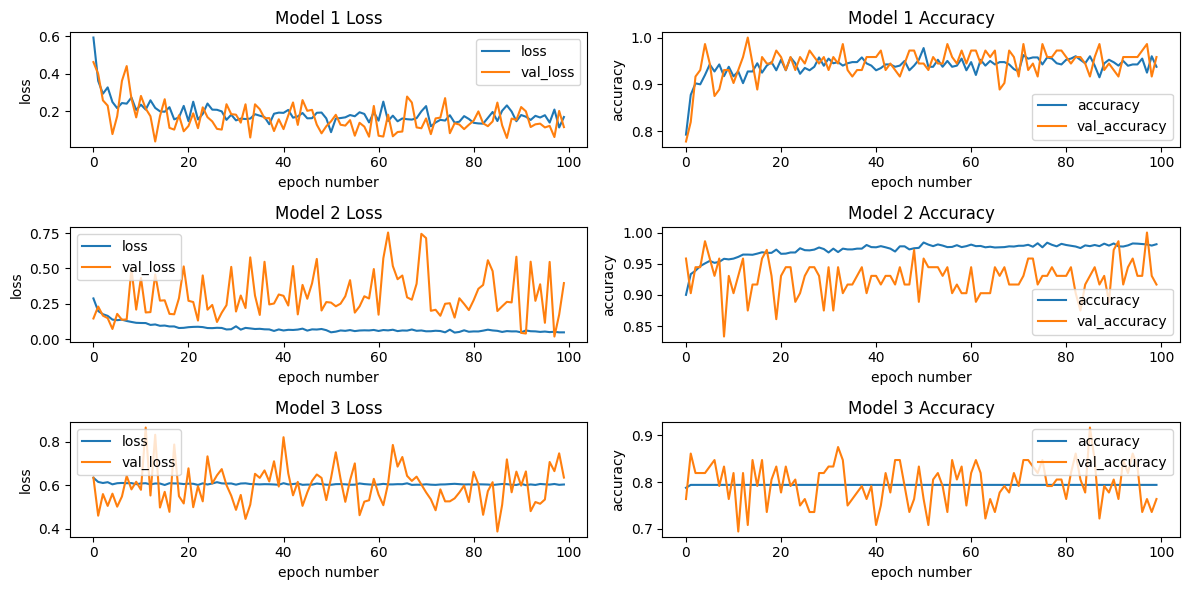

In [40]:
plot_loss_and_accuracy([model_custom_history.history, model_mobilenet_history.history, model_effNet_history.history])

In [49]:
import cv2

filenames = './model_effNet.h5'
paths = test_generator.filenames # Your files path
y_pred_custom = model_custom.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices
classes = test_generator.class_indices  # Map of Indices to Class name

a_img_rand = np.random.randint(0,len(paths))   # A rand to pick a rand image
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#img = image.img_to_array(img)
plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred_custom[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label} for Custom Model')

InvalidArgumentError: Graph execution error:

Detected at node sequential/dense/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_8504\4118296433.py", line 1, in <module>

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2631, in predict

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2416, in predict_function

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2401, in step_function

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2389, in run_step

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2357, in predict_step

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 589, in __call__

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py", line 255, in call

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\activations.py", line 306, in relu

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py", line 5397, in relu

Matrix size-incompatible: In[0]: [8,9216], In[1]: [1024,500]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_predict_function_60032]

In [ ]:
y_pred_MobileNet = model_custom.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred_MobileNet[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label} for Mobile Net Model')

In [42]:
y_pred_EfficientNet = model_custom.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred_EfficientNet[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label} for Efficient Net Model')

InvalidArgumentError: Graph execution error:

Detected at node sequential/dense/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_8504\4118296433.py", line 1, in <module>

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2631, in predict

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2416, in predict_function

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2401, in step_function

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2389, in run_step

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2357, in predict_step

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 589, in __call__

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py", line 255, in call

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\activations.py", line 306, in relu

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py", line 5397, in relu

Matrix size-incompatible: In[0]: [8,9216], In[1]: [1024,500]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_predict_function_60032]

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_models(true_labels, pred_labels1, pred_labels2, pred_labels3):
    fig, ax = plt.subplots(3,1, figsize=(12, 6))
    # Classification report for model 1
    print("Custom Model Classification Report:\n")
    print(classification_report(true_labels, pred_labels1))
    # Confusion matrix for model 1
    print("Custom Model Confusion Matrix:\n")
    cm1 = confusion_matrix(true_labels, pred_labels1)
    sns.heatmap(cm1,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20}, ax=axes[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Custom Model Confusion Matrix')

    # Classification report for model 2
    print("Model MobileNet Classification Report:\n")
    print(classification_report(true_labels, pred_labels2))
    # Confusion matrix for model 2
    print("Model MobileNet Confusion Matrix:\n")
    cm2 = confusion_matrix(true_labels, pred_labels2)
    sns.heatmap(cm2,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20}, ax=axes[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'MobileNet Confusion Matrix')

    # Classification report for model 3
    print("Efficient Model Classification Report:\n")
    print(classification_report(true_labels, pred_labels3))
    # Confusion matrix for model 3
    print("Efficient Model Confusion Matrix:\n")
    cm3 = confusion_matrix(true_labels, pred_labels3)
    sns.heatmap(cm3,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20}, ax=axes[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Efficient Model Confusion Matrix')

    
    
    plt.show()

In [44]:
y_true = test_generator.labels
y_pred_custom  = model_custom.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

y_pred_mobileNet  = model_mobilenet.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

y_pred_EffNet  = model_effNet.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

# evaluate_models(y_true, y_pred_custom, y_pred_mobileNet, y_pred_EffNet)

InvalidArgumentError: Graph execution error:

Detected at node sequential/dense/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_8504\4118296433.py", line 1, in <module>

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2631, in predict

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2416, in predict_function

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2401, in step_function

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2389, in run_step

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2357, in predict_step

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 589, in __call__

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py", line 255, in call

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\activations.py", line 306, in relu

  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py", line 5397, in relu

Matrix size-incompatible: In[0]: [8,9216], In[1]: [1024,500]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_predict_function_60032]

In [45]:
# Use bincount() to count occurrences of each class in a predictions NumPy array
c_1,c_2,c_3 = np.bincount(y_pred_custom),np.bincount(y_pred_mobileNet),np.bincount(y_pred_EffNet) 
print(f'The Count of Occurences of Each Class in Each Model is Give below : ')
print(f'1. Custom Model : {c_1}')
print(f'2. MobileNet Model : {c_2}')
print(f'3. EfficientNet Model : {c_3}')

NameError: name 'y_pred_custom' is not defined

In [ ]:
import cv2
img = cv2.imread(os.path.join(input_data_path, f'{final_test_image}.png'))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#print(type(colored_img))
mask_label = {0:'MASK INCORRECT',1:'MASK', 2:'NO MASK'}
color_label = {0:(0,255,255),1:(0, 255,0), 2:(255,0,0)}
cropped_faces = extract_faces(f'{final_test_image}.png', df_final_test)

df_test_img = df_final_test[['xmin', 'ymin', 'xmax', 'ymax', 'label']]
#df_test_img
#for row_num in range(len(df_test_img)):
for idx, face in enumerate(cropped_faces):    
    #print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    #print(x_min, y_min, x_max, y_max, label)
    #print(face[0])
    resized_face = cv2.resize(np.array(face[0]),(35,35))
    reshaped_face = np.reshape(resized_face,[1,35,35,3])/255.0

    face_result = model_custom.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)

In [47]:
for idx, face in enumerate(cropped_faces):    
    #print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    #print(x_min, y_min, x_max, y_max, label)
    #print(face[0])
    resized_face = cv2.resize(np.array(face[0]),(96,96))
    reshaped_face = np.reshape(resized_face,[1,96,96,3])/255.0

    face_result = model_mobilenet.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)

NameError: name 'df_test_img' is not defined

In [46]:
for idx, face in enumerate(cropped_faces):    
    #print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    #print(x_min, y_min, x_max, y_max, label)
    #print(face[0])
    resized_face = cv2.resize(np.array(face[0]),(96,96))
    reshaped_face = np.reshape(resized_face,[1,96,96,3])/255.0

    face_result = model_effNet.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)

NameError: name 'df_test_img' is not defined